In [538]:
import numpy as np
import dill
import importlib
import sys
import os
import matplotlib.pyplot as plt
'''
This scrip uses the optimal stopping model and then tunes the decision times so that they match some metric

Available metrics as of 3/3/23
  - Leave Target Time
  - Wins
  - Indecisions
  - Incorrects
'''

'\nThis scrip uses the optimal stopping model and then tunes the decision times so that they match some metric\n\nAvailable metrics as of 3/3/23\n  - Leave Target Time\n  - Wins\n  - Indecisions\n  - Incorrects\n'

In [539]:
sys.path.insert(0, r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Modeling_Scripts\Optimal Stopping') 
sys.path.insert(0, r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics') 
sys.path.insert(0, r'D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement') 

import Optimal_Stopping_Object_v3
from Subject_Object import *
from plot_functions import *
importlib.reload(Optimal_Stopping_Object_v3) # Reloads so I don't have to restart kernel if I change a function in the Object of another py file

<module 'Optimal_Stopping_Object_v3' from 'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\Exp1\\Scripts\\Modeling_Scripts\\Optimal Stopping\\Optimal_Stopping_Object_v3.py'>

# Initial Thangs

In [540]:
plt.style.use('cashaback_dark')
wheel = dv.ColorWheel()

# Initial thangs
os.chdir('D:\OneDrive - University of Delaware - o365\Subject_Data\Seth_MatchPennies_Agent_Exp1')
PATH = os.getcwd()
SAVE_PATH = r'C:\Users\Seth Sullivan\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\\Simulation_Figures\\Group\\'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

# Fields pull and pull list
figures_pull_list = []
figures_pull_list_control = []
figures_pull_list_task = []
fields_pull = []
with open(PATH+"\\Figures_Pull_List.txt", "r") as pull_file:
    figures_pull_list = pull_file.read().splitlines()
with open(PATH+"\\Fields_Pull.txt", "r") as fields_pull:
    fields_pull = fields_pull.read().splitlines()
num_subjects = len(figures_pull_list)
task_name = 'Seth_MatchPennies_Agent_Exp1'
tp3_title = "1000 (50)"
tp4_title = "1000 (150)"
tp5_title = '1100 (50)'
tp6_title = "1100 (150)"
tp7_title = "1200 (50)"
tp8_title = '1200 (150)'
trial_block_titles = [tp3_title, tp4_title, tp5_title,tp6_title, tp7_title, tp8_title]
num_blocks = len(trial_block_titles)

# Pickle Data

In [541]:
NUM_STDS = 2
append_dict = {0:'reaction_time_no_sd_off',1:'reaction_time_minus_sd',2:'reaction_time_minus_2sd'}
load_path = r'D:\OneDrive - University of Delaware - o365\Subject_Data\Seth_MatchPennies_Agent_Exp1\Subjects_Analyzed\\'
subject = dill.load((open(load_path + f'subject_object_{append_dict[NUM_STDS]}_dict.pkl', 'rb')))
group = dill.load((open(load_path + f'group_object_{append_dict[NUM_STDS]}.pkl', 'rb')))
group.analyze_data()

D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:478: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_wins_mean                      = np.nanmean(self.combine_all_subjects('perc_binned_player_wins'),axis = 0)
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:479: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_indecisions_mean               = np.nanmean(self.combine_all_subjects('perc_binned_player_indecisions'),axis = 0)
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Analysis_and_Statistics\Subject_Object.py:480: RuntimeWarning: Mean of empty slice
  self.perc_binned_player_incorrects_mean                = np.nanmean(self.combine_all_subjects('perc_binned_player_incorrects'),axis = 0)
D:\OneDrive - University of Delaware - o365\Desktop\Ma

# Create Model

In [542]:

group_model_optimal = Optimal_Stopping_Object_v3.Optimal_Decision_Time_Model(reaction_time = group.adjusted_reaction_time_mean+30, movement_time = np.mean(group.player_task_movement_time_median), incorrect_cost = 0,
                                          reaction_uncertainty = group.reaction_time_sd, movement_uncertainty = group.reaction_movement_time_sd,
                                          timing_uncertainty = np.array([group.coincidence_reach_time_sd]*6),#group.all_player_sd_gamble_leave_time[1],
                                          decision_action_delay_uncertainty = 10, decision_action_delay_mean = 50,
                                          unknown_gamble_uncertainty_on = False, unknown_gamble_uncertainty = 100,
                                          unknown_gamble_delay_on = False, unknown_gamble_delay = 175,
                                          known_gamble_uncertainty_on = True, known_gamble_uncertainty = group.all_player_sd_gamble_leave_time,
                                          known_gamble_delay_on = True, known_gamble_delay = 125,
                                          weird_reaction_gamble_cutoff = 0
                                         ) 
group_model_optimal.run_model()
group_model_tuned = group_model_optimal


D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Modeling_Scripts\Optimal Stopping\Optimal_Stopping_Object_v3.py:89: RuntimeWarning: invalid value encountered in subtract
  return EX2 - EX**2
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Modeling_Scripts\Optimal Stopping\Optimal_Stopping_Object_v3.py:86: RuntimeWarning: invalid value encountered in subtract
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Modeling_Scripts\Optimal Stopping\Optimal_Stopping_Object_v3.py:86: RuntimeWarning: invalid value encountered in power
  ans = (EX3 - 3*EX*(EX2 - EX**2) - EX**3)/((EX2 - EX**2)**(3/2))
D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\Exp1\Scripts\Modeling_Scripts\Optimal Stopping\Optimal_Stopping_Object_v3.py:232: RuntimeWarning: invalid value encou

Run subject models to predict the true decision time given the 

In [543]:
o = group_model_tuned
print(f'Reaction Time Mean (SD):         {o.reaction_time} ({o.reaction_uncertainty})')
print(f'Movement Time Mean (SD):         {o.movement_time} ({o.movement_uncertainty})')
print(f'Timing Uncertainty:              {o.timing_uncertainty}')
print(f'Decision Action Delay Mean (SD): {o.decision_action_delay_mean} ({o.decision_action_delay_uncertainty})')
print(f'Unknown Gamble Delay:            {o.unknown_gamble_delay_on}-{o.unknown_gamble_delay}')
print(f'Known Gamble Delay:              {o.known_gamble_delay_on}-{o.known_gamble_delay}')
print(f'Unknown Gamble Uncertainty:      {o.unknown_gamble_uncertainty_on}-{o.unknown_gamble_uncertainty}')
print(f'Known Gamble Uncertainty:        {o.known_gamble_uncertainty_on}-{o.known_gamble_uncertainty}')
print(f'Reaction Gamble Cutoff:          {o.weird_reaction_gamble_cutoff}')


Reaction Time Mean (SD):         279.5919769223312 (31.856511538834404)
Movement Time Mean (SD):         137.66666666666666 (31.985228216730796)
Timing Uncertainty:              [69.341615 69.341615 69.341615 69.341615 69.341615 69.341615]
Decision Action Delay Mean (SD): 50 (10)
Unknown Gamble Delay:            False-175
Known Gamble Delay:              True-125
Unknown Gamble Uncertainty:      False-100
Known Gamble Uncertainty:        True-[115.66390765 128.11356608 103.37327089 137.43352393 130.64306632
 145.64002818]
Reaction Gamble Cutoff:          0


# Fine Tune the Decision Times for the Tuned Model 

Fit model to data

In [544]:
data_wins = np.median(group.combine_all_subjects('player_perc_wins'),axis=0)
data_indecisions = np.median(group.combine_all_subjects('player_perc_indecisions'),axis=0)
data_incorrects = np.median(group.combine_all_subjects('player_perc_incorrects'),axis=0)
data_leave_target_time = np.median(group.combine_all_subjects('player_task_leave_time_median') ,axis=0)
data_reaction_decisions = np.median(group.combine_all_subjects('perc_reaction_decisions'),axis=0)
data_gamble_decisions = np.median(group.combine_all_subjects('perc_gamble_decisions'),axis=0)
data_reaction_leave_time = np.nanmedian(group.combine_all_subjects('player_reaction_leave_time_median'),axis=0)
data_gamble_leave_time = np.nanmedian(group.combine_all_subjects('player_gamble_leave_time_median'),axis=0)
tune_data = [data_wins,data_indecisions,data_incorrects,data_leave_target_time,
             data_reaction_decisions,data_gamble_decisions,data_reaction_leave_time,data_gamble_leave_time]
group_model_tuned.fit_model_to_data(tune_data)
group_model = group_model_tuned


In [545]:
data_reaction_leave_time

array([1287.75, 1246.75, 1367.25, 1289.  , 1448.  , 1325.  ])

Select data I want to get decision times for

In [546]:
group_model.optimal_decision_time

array([1799, 1799, 1799, 1799, 1799, 1799])

In [547]:
group_model.calculate_metrics_with_certain_decision_time(group_model.fit_decision_times_dict['Leave Target Time'])

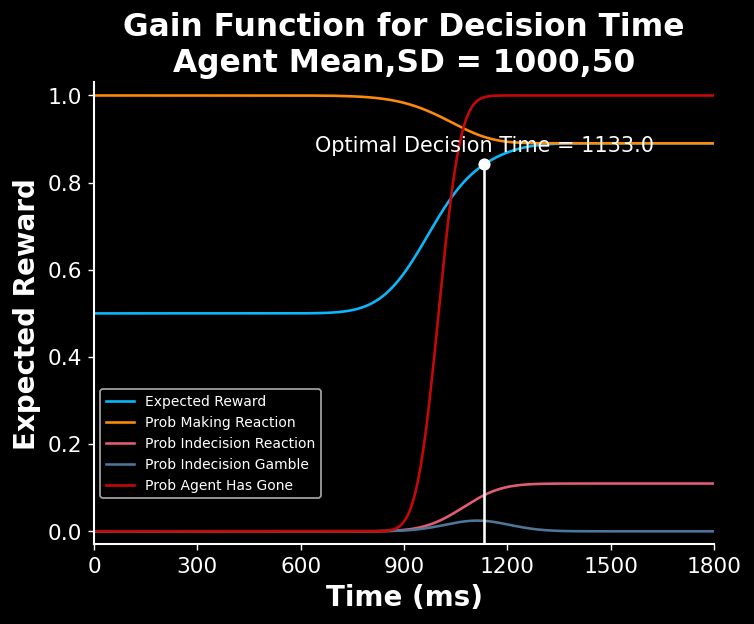

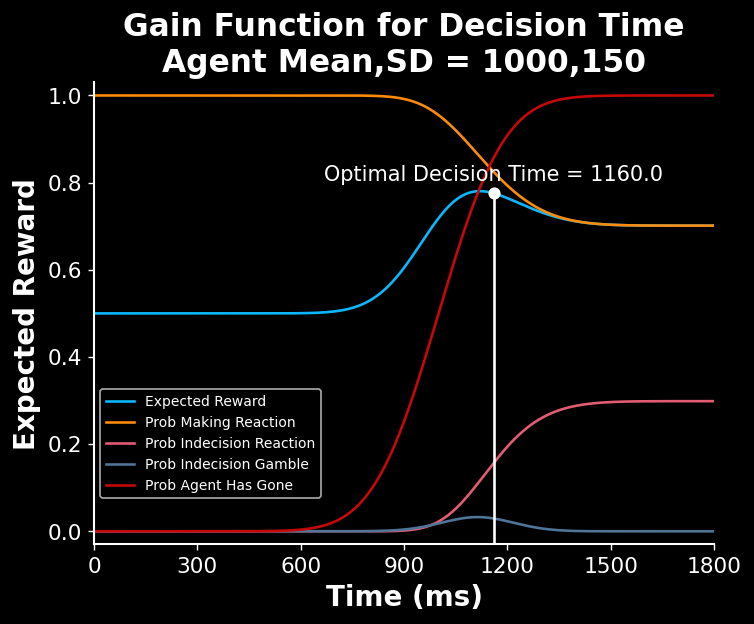

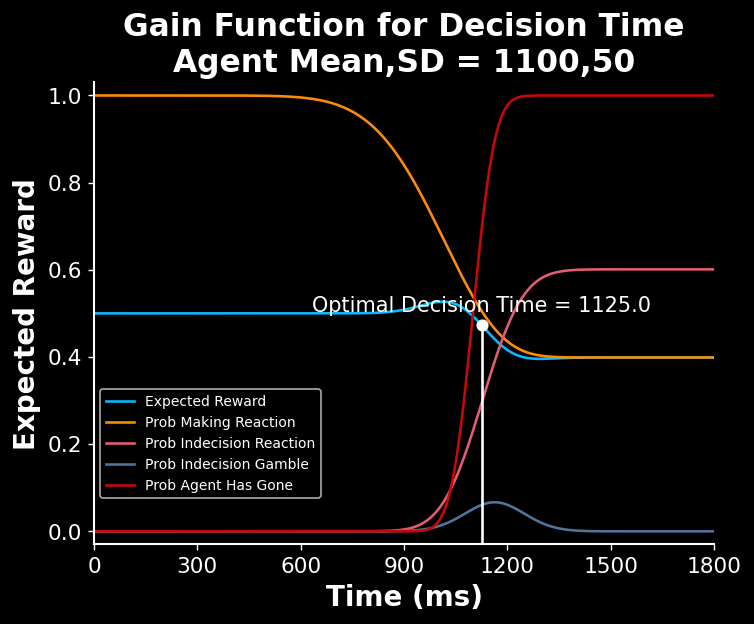

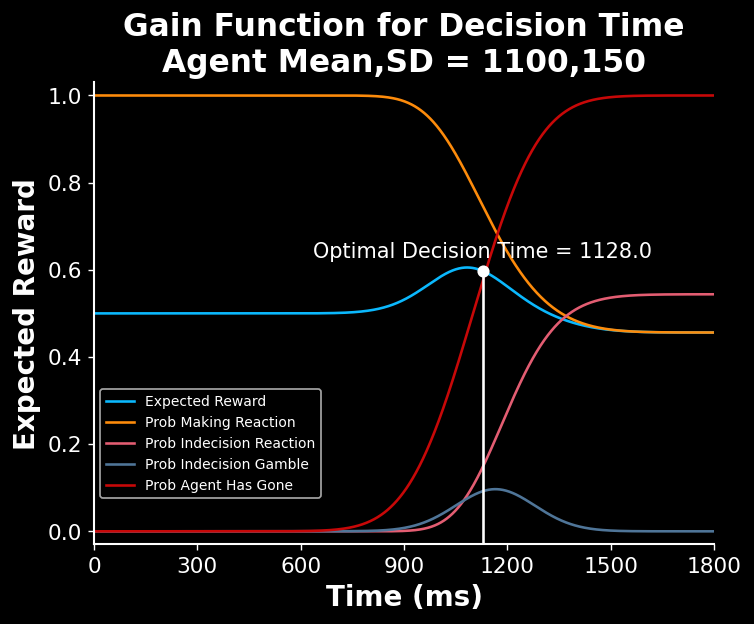

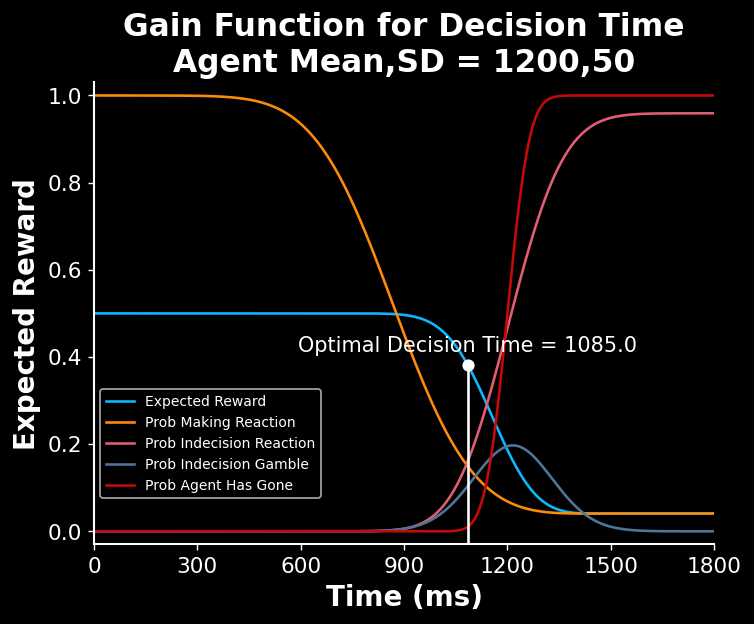

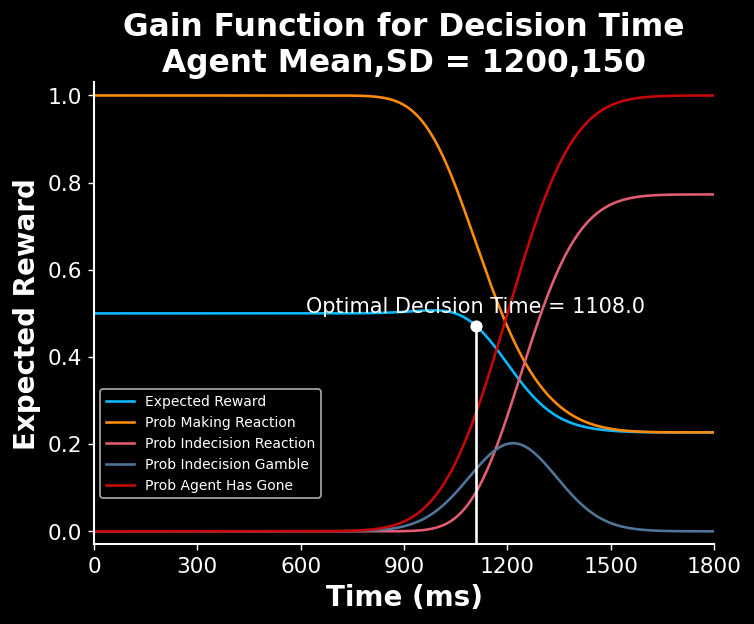

In [548]:
group_model.plot_optimals(metrics = ['exp_reward','prob_making_reaction','prob_indecision_reaction','prob_indecision_gamble','prob_agent_has_gone'])#,'exp_reward_reaction','exp_reward_gamble','prob_selecting_reaction'])

In [549]:
group_model.fit_decision_times_dict['Leave Target Time']

array([1133., 1160., 1125., 1128., 1085., 1108.])

# Plots

Predict Decision Times

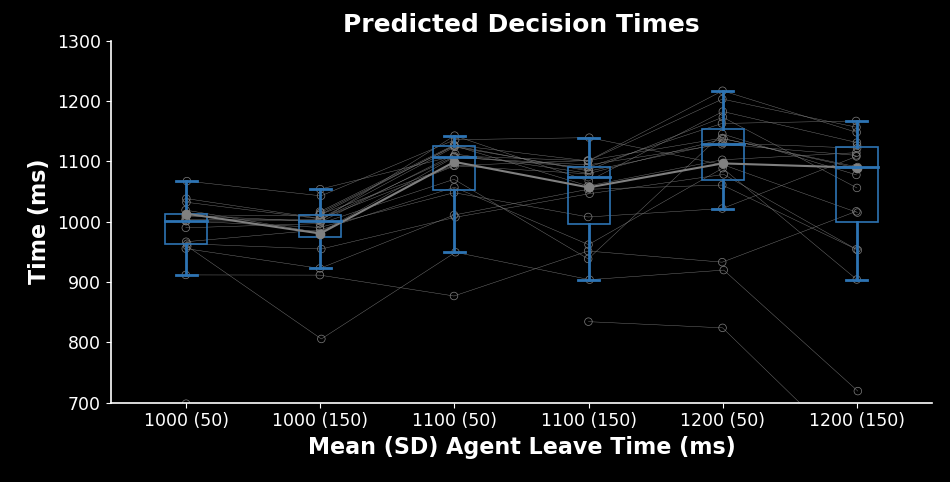

In [550]:
save = False
'''
Predicted decision times are calculated for each subject based on their percentage of reactions and gambles
- The reaction decision time is the agent leave time, the gamble decision time = gamble_leave_time - gamble_delay

Also calculated the same way for the model
'''

group.predict_decision_times(group_model_tuned.gamble_delay,0)
metric = group.player_predicted_decision_time
optimal_metric = group_model.predicted_decision_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(700,1400,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='grey',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Predicted Decision Times')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Predicted Stopping Times

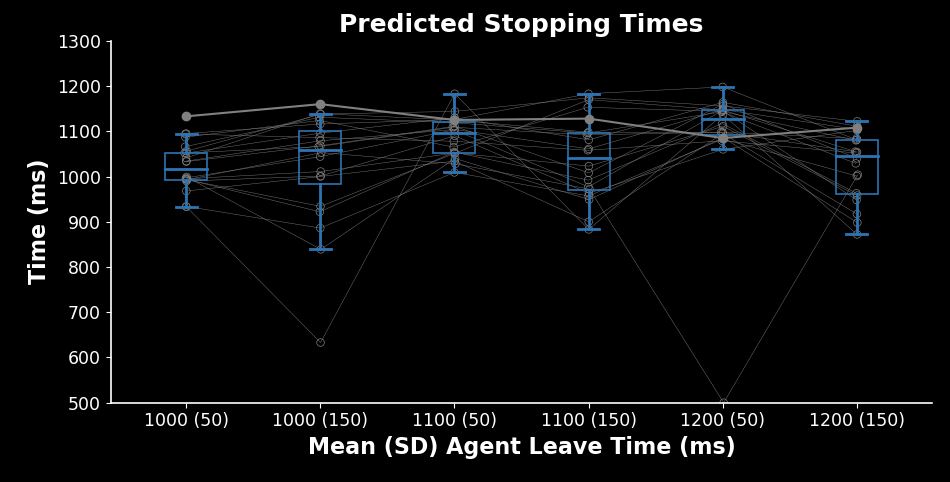

In [551]:
save = False
metric = group.predicted_stopping_time
optimal_metric = group_model.optimal_decision_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(500,1400,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='grey',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Predicted Stopping Times')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()


plt.show()

Predicted Reaction and Gamble Decisions

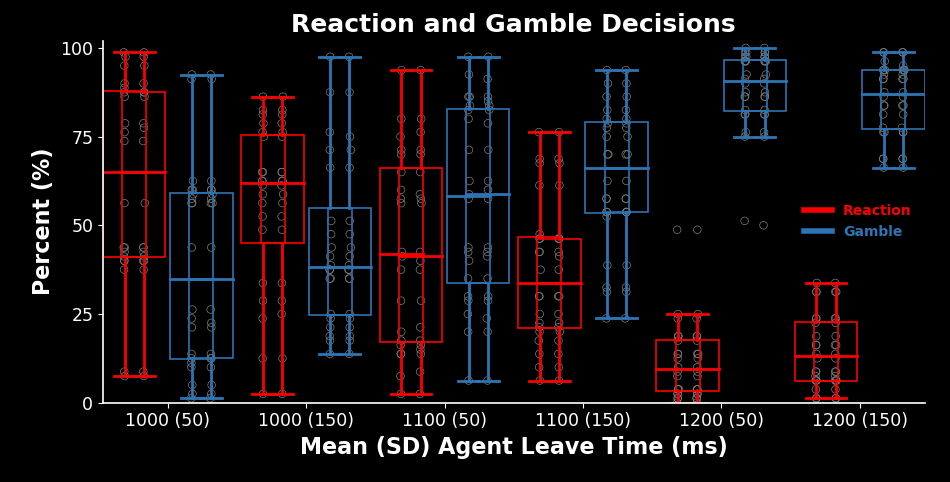

In [552]:
optimal_metric1 = group.final_predicted_perc_reaction_decisions
optimal_metric2 = group.final_predicted_perc_gamble_decisions
data_metric1 = group.combine_all_subjects('perc_reaction_decisions')
data_metric2 = group.combine_all_subjects('perc_gamble_decisions')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
multi_boxplot(ax,optimal_metric1,xlocs=xlocs-bw,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw,data_list=optimal_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
multi_boxplot(ax,optimal_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=optimal_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Reaction and Gamble Decisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

LEave Target Time

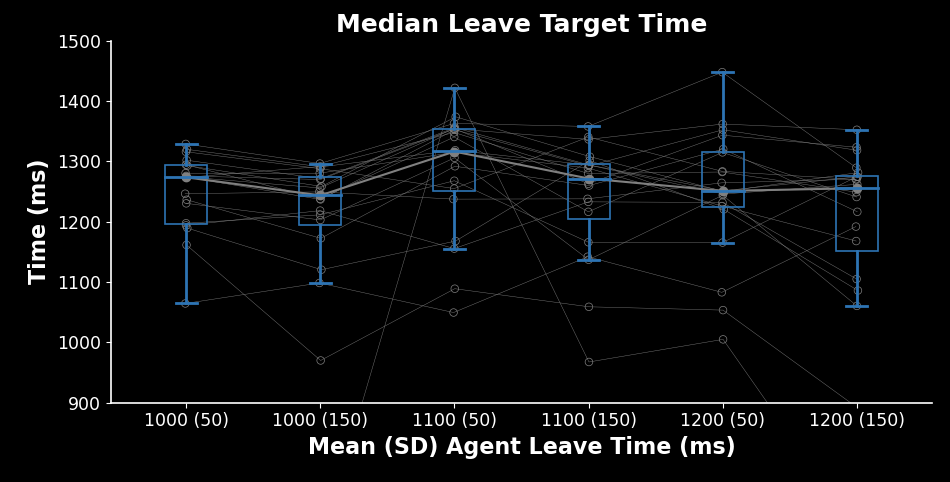

In [553]:
metric = group.combine_all_subjects('player_task_leave_time_median') 
optimal_metric = group_model.wtd_optimal_leave_target_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(900,1600,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='grey',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Median Leave Target Time')
if save:
    plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()


plt.show()

Player Minus Agent Mean Leave Target Time

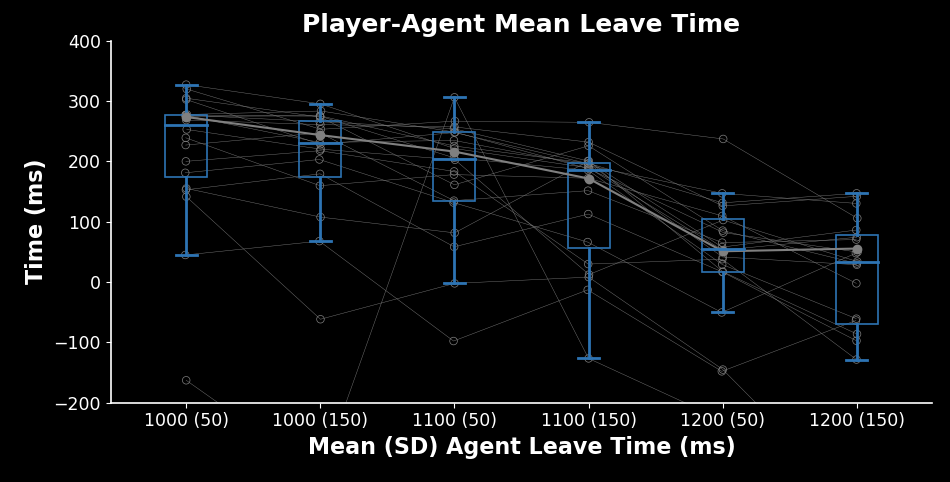

In [554]:
metric = group.combine_all_subjects('player_minus_agent_task_leave_time_mean') 
optimal_metric = group_model.player_minus_agent_leave_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.3,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(-200,500,100)
bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='grey',marker='o')


ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_xlim(min(xlocs)-1.8*bw,max(xlocs)+1.8*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Time (ms)')
ax.set_title('Player-Agent Mean Leave Time')
if save:
    axmain.set_axis_off()
    # plt.savefig(SAVE_PATH+'mean_leave_target_time_with_optimal_simulation', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Wins

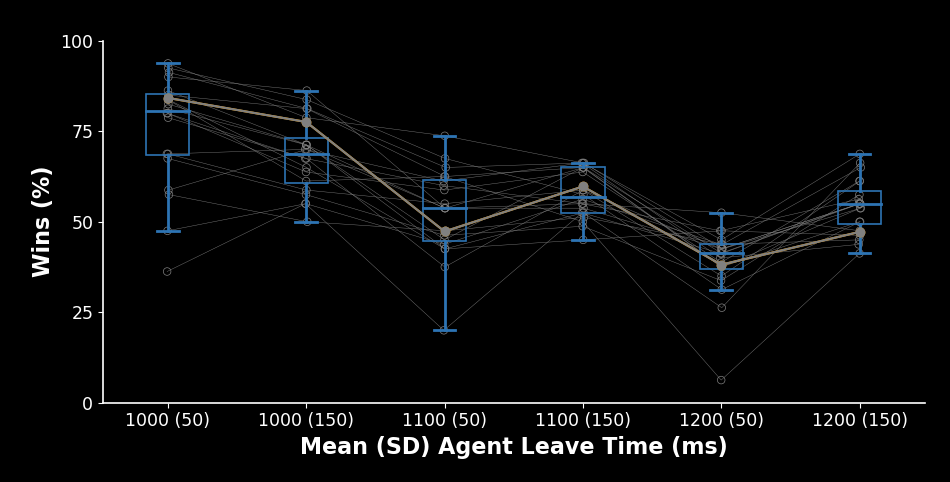

In [555]:
metric = group.combine_all_subjects('player_perc_wins') 
optimal_metric = group_model.prob_win_optimal*100
optimal_metric_calc = group_model.perc_win_calc

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='orange',marker='o')
ax.plot(xlocs,optimal_metric_calc,c='grey',marker='o')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Wins (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'wins_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Indecisions

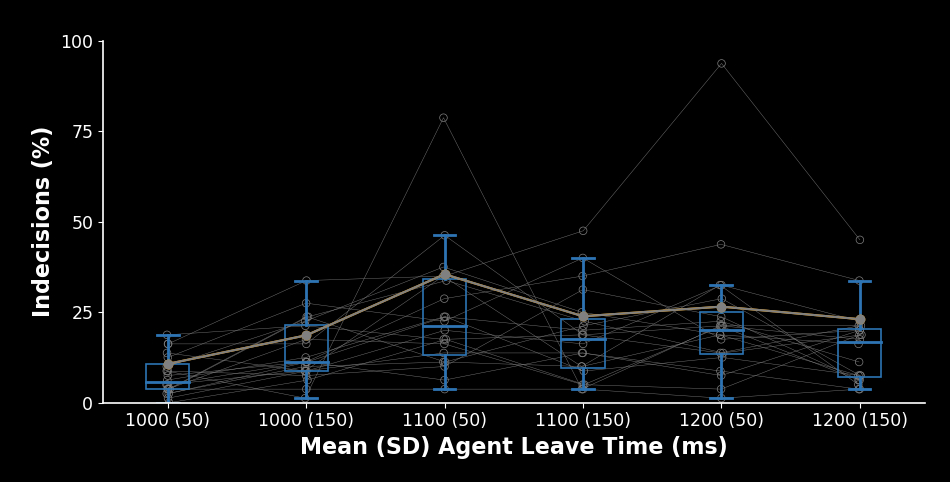

In [556]:
metric = group.combine_all_subjects('player_perc_indecisions') 
optimal_metric = group_model.prob_indecision_optimal*100
optimal_metric_calc = group_model.perc_indecision_calc

# optimal_metric = group_model.prob_indecision_based_on_reach_time
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='orange',marker='o')
ax.plot(xlocs,optimal_metric_calc,c='grey',marker='o')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Indecisions (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'indecisions_with_optimal_model', dpi = 400, transparent = True)
    
axmain.set_axis_off()

plt.show()

Incorrects

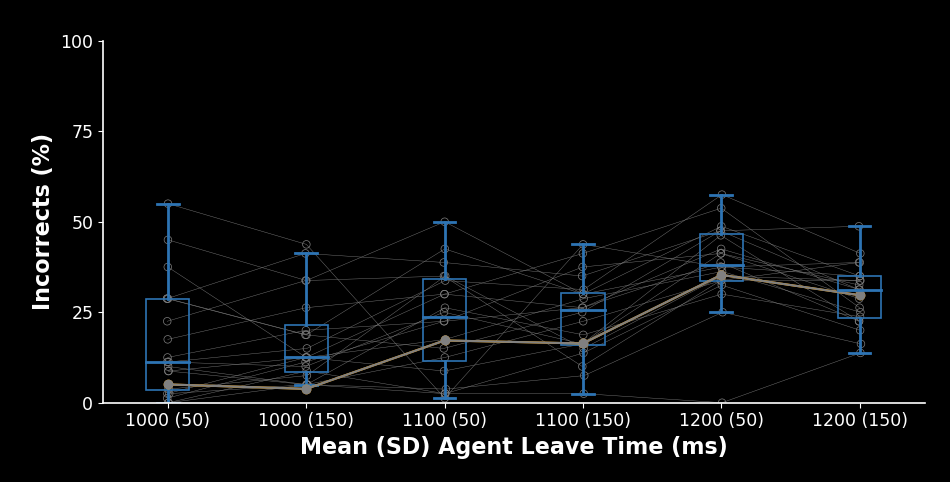

In [557]:
metric = group.combine_all_subjects('player_perc_incorrects') 
optimal_metric = group_model.prob_incorrect_optimal*100
optimal_metric_calc = group_model.perc_incorrect_calc

w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)

bw = 0.75
multi_boxplot(ax,metric,xlocs=xlocs,box_width = bw,colors = wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs,data_list=metric.T, noise_scale=0.01, include_mean = False, circle_size=30)

ax.plot(xlocs,optimal_metric,c='orange',marker='o')
ax.plot(xlocs,optimal_metric_calc,c='grey',marker='o')

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))
ax.set_xticks(xlocs),ax.set_yticks(ylocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylim(0,100)
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_ylabel('Incorrects (%)')
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'incorrects_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Gamble Decisions

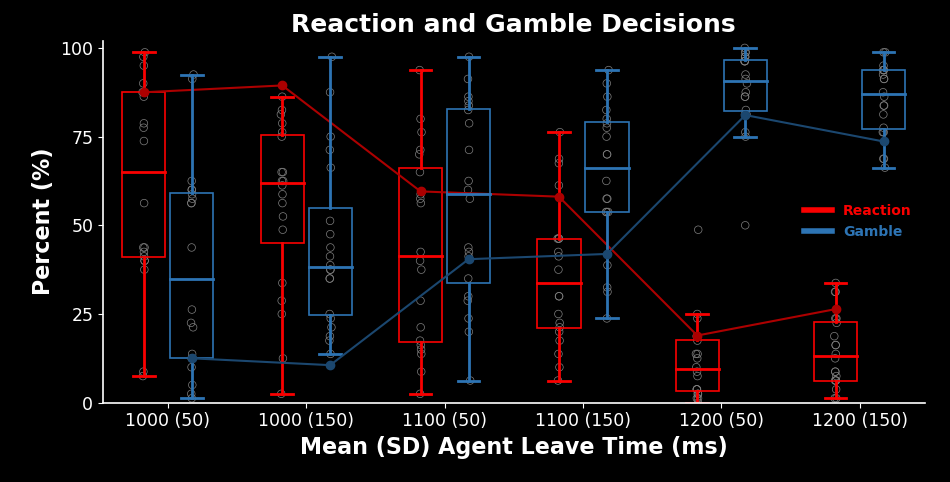

In [558]:
optimal_metric1 = group_model.prob_selecting_reaction_optimal*100
optimal_metric2 = group_model.prob_selecting_gamble_optimal*100
data_metric1 = group.combine_all_subjects('perc_reaction_decisions')
data_metric2 = group.combine_all_subjects('perc_gamble_decisions')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Percent (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Reaction and Gamble Decisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_decisions_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Gamble Leave Times

Reaction and Gamble Leave Times

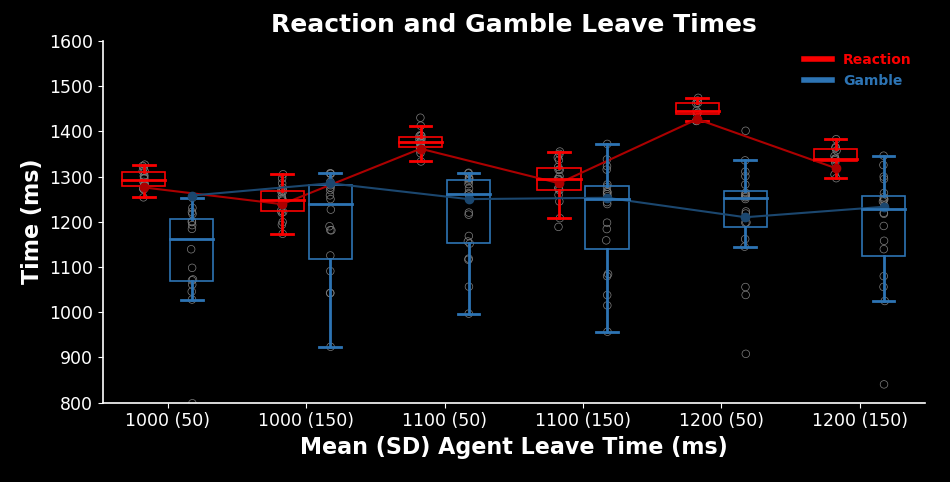

In [559]:
optimal_metric1 = group_model.optimal_reaction_leave_target_time
optimal_metric2 = group_model.optimal_gamble_leave_target_time
data_metric1 = group.combine_all_subjects('player_reaction_leave_time_mean')
data_metric2 = group.combine_all_subjects('player_gamble_leave_time_mean')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(800,1700,100)

bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Reaction and Gamble Leave Times')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_leave_times_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

PLayer Minus Agent Reaction and Gamble Leave Times

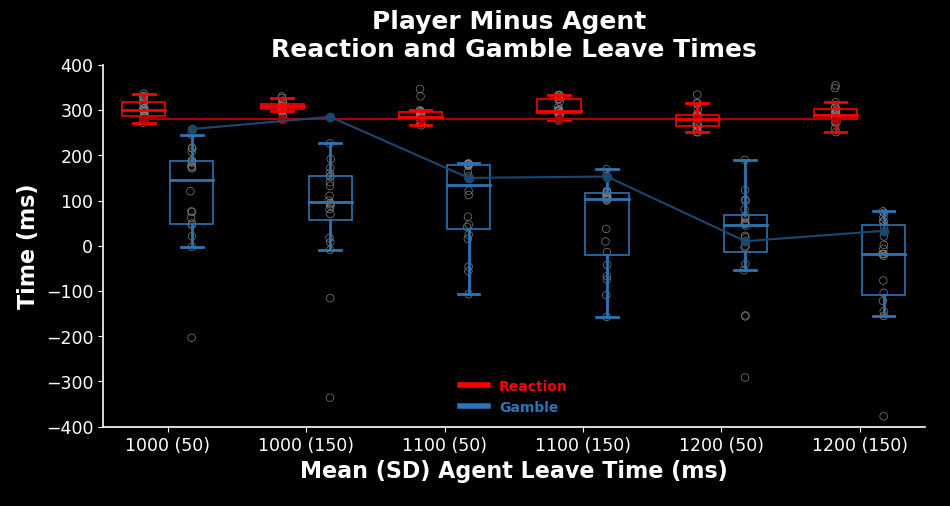

In [560]:
optimal_metric1 = [group_model.player_minus_agent_reaction_leave_time]*6
optimal_metric2 = group_model.player_minus_agent_gamble_leave_time
data_metric1 = group.combine_all_subjects('player_minus_agent_reaction_leave_time_mean')
data_metric2 = group.combine_all_subjects('player_minus_agent_gamble_leave_time_mean')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(-400,500,100)


bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Player Minus Agent \nReaction and Gamble Leave Times')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_leave_times_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Reaction and Gamble LEave time SD


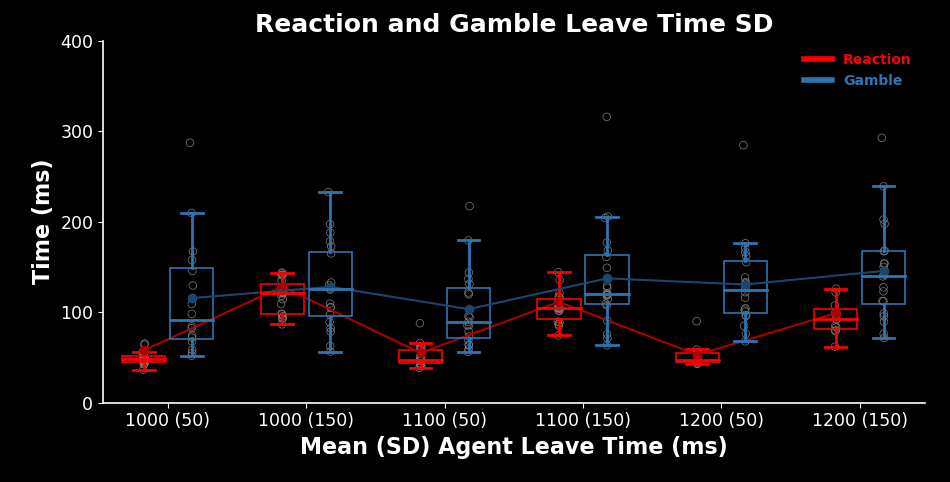

In [561]:
optimal_metric1 = group_model.optimal_reaction_leave_target_time_sd
optimal_metric2 = group_model.optimal_gamble_leave_target_time_sd
data_metric1 = group.combine_all_subjects('player_reaction_leave_time_sd')
data_metric2 = group.combine_all_subjects('player_gamble_leave_time_sd')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,500,100)

bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Reaction and Gamble Leave Time SD')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_leave_times_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Gamble Leave Times

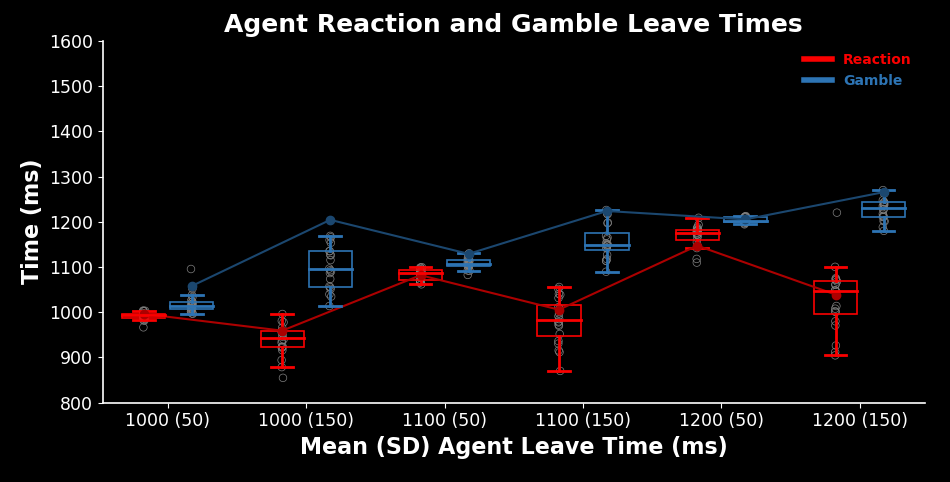

In [562]:
optimal_metric1 = group_model.cutoff_agent_reaction_mean_optimal
optimal_metric2 = group_model.cutoff_agent_gamble_mean_optimal
data_metric1 = group.combine_all_subjects('agent_reaction_leave_time_mean')
data_metric2 = group.combine_all_subjects('agent_gamble_leave_time_mean')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(800,1700,100)

bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Agent Reaction and Gamble Leave Times')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_agent_leave_times_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Agent SD Reaction and Gamble Leave Times

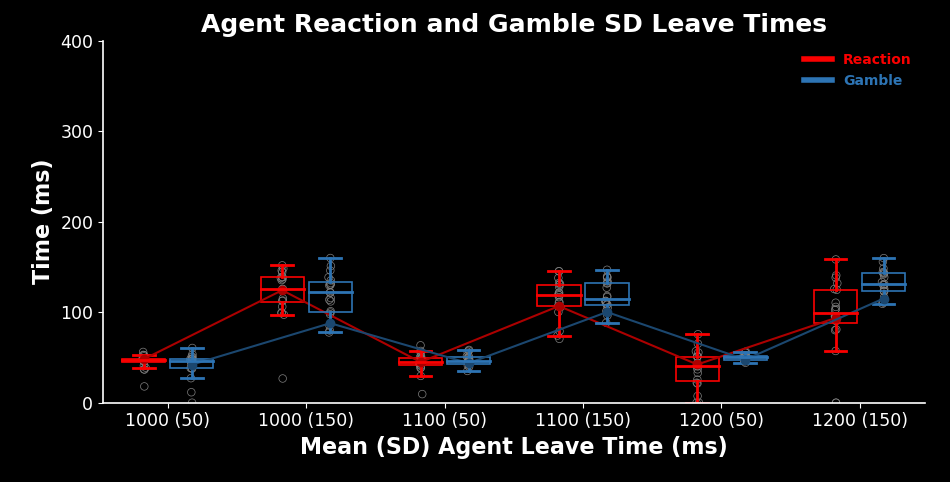

In [563]:
optimal_metric1 = group_model.cutoff_agent_reaction_sd_optimal
optimal_metric2 = group_model.cutoff_agent_gamble_sd_optimal
data_metric1 = group.combine_all_subjects('agent_reaction_leave_time_sd')
data_metric2 = group.combine_all_subjects('agent_gamble_leave_time_sd')

# Out of x number of reaction and gamble decisions, how many of them were indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,500,100)

bw = 0.75
multi_boxplot(ax,data_metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=data_metric1.T,lw = 0, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,data_metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=data_metric2.T, lw=0,noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Agent Reaction and Gamble SD Leave Times')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH+'reaction_and_gamble_agent_leave_times_with_optimal_model', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Wins That Were Gambles

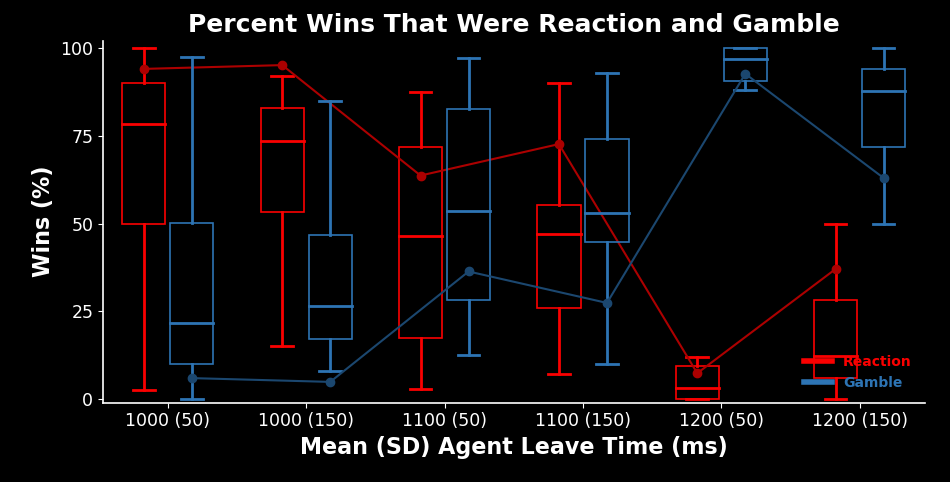

In [564]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
metric1 = group.combine_all_subjects('perc_wins_that_were_reactions') 
metric2 = group.combine_all_subjects('perc_wins_that_were_gambles') 
optimal_metric1 = group_model.perc_wins_that_were_reaction
optimal_metric2 = group_model.perc_wins_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Percent Wins That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Gambles

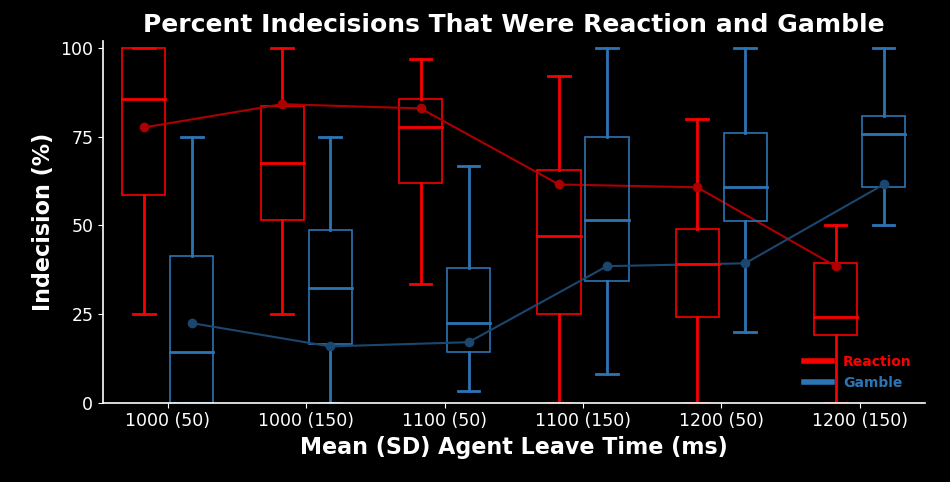

In [565]:
# Out of x number of indecisions, how many were reaction and gamble
metric1 = group.combine_all_subjects('perc_indecisions_that_were_reactions') 
metric2 = group.combine_all_subjects('perc_indecisions_that_were_gambles') 
optimal_metric1 = group_model.perc_indecisions_that_were_reaction
optimal_metric2 = group_model.perc_indecisions_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(0,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Indecision (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Percent Indecisions That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'reaction_and_gamble_indecisions', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent Incorrects That Were Gambles

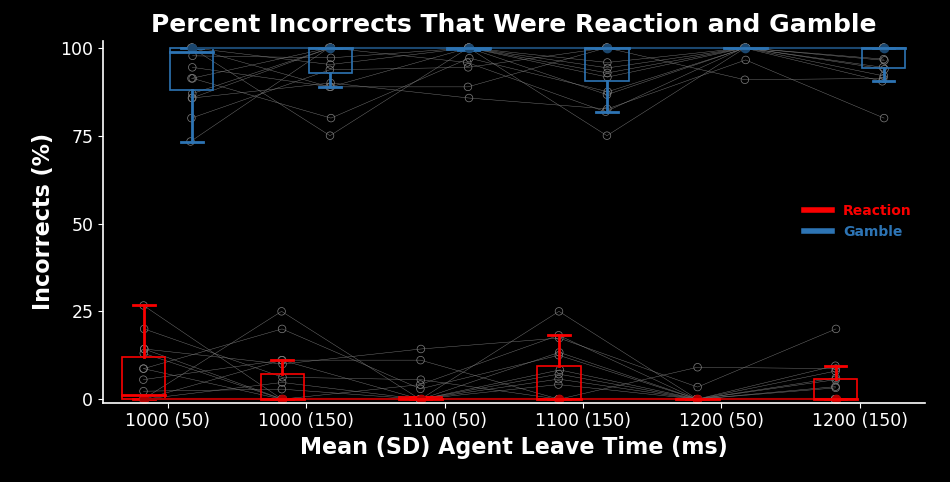

In [566]:
# Out of x number of reaction and gamble decisions, how many of them were indecisions
metric1 = group.combine_all_subjects('perc_incorrects_that_were_reactions') 
metric2 = group.combine_all_subjects('perc_incorrects_that_were_gambles') 
optimal_metric1 = group_model.perc_incorrects_that_were_reaction
optimal_metric2 = group_model.perc_incorrects_that_were_gamble
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Incorrects (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Percent Incorrects That Were Reaction and Gamble')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent of Reaction and Gambles that were Wins

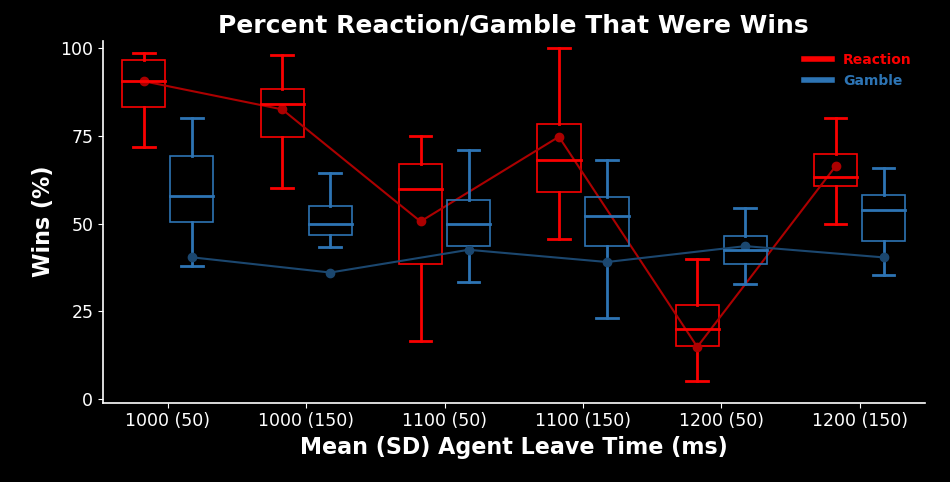

In [567]:
# Out of x number of reaction and gamble decisions, how many of them were wins
metric1 = group.combine_all_subjects('perc_reactions_that_were_wins') 
metric2 = group.combine_all_subjects('perc_gambles_that_were_wins') 
optimal_metric1 = group_model.perc_reactions_that_were_wins
optimal_metric2 = group_model.perc_gambles_that_were_wins
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Percent Reaction/Gamble That Were Wins')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent of Reaction and Gambles that were Indecisions

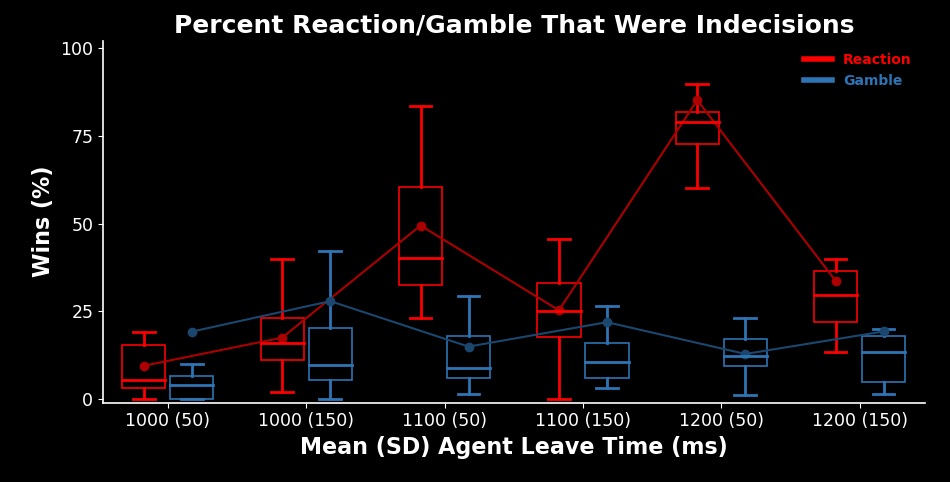

In [568]:
#!!!!!!!!!!!! Out of x number of reaction and gamble decisions, how many of them were indecisions!!!!!!!
metric1 = group.combine_all_subjects('perc_reactions_that_were_indecisions') 
metric2 = group.combine_all_subjects('perc_gambles_that_were_indecisions') 
optimal_metric1 = group_model.perc_reactions_that_were_indecisions
optimal_metric2 = group_model.perc_gambles_that_were_indecisions
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Percent Reaction/Gamble That Were Indecisions')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()

Percent of Reaction and Gambles that were Wins

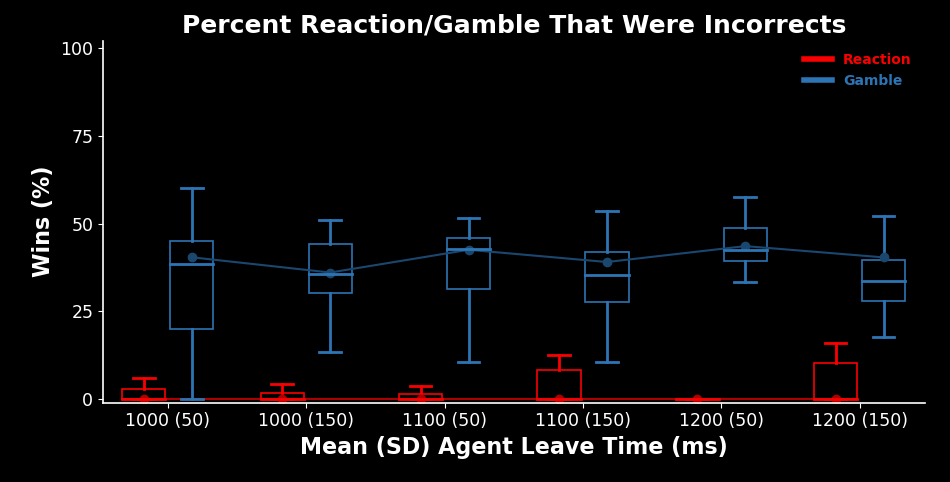

In [569]:
metric1 = group.combine_all_subjects('perc_reactions_that_were_incorrects') 
metric2 = group.combine_all_subjects('perc_gambles_that_were_incorrects') 
optimal_metric1 = group_model.perc_reactions_that_were_incorrects
optimal_metric2 = group_model.perc_gambles_that_were_incorrects
w,h = 12,6
axmain,ax = make_figure_panel(figsize=(w,h),inset_size=(1.2,0.9,w-1.4,h-1.3))
xlocs = np.linspace(0,w,num=len(trial_block_titles))
ylocs = np.arange(0,125,25)


bw = 0.75
multi_boxplot(ax,metric1,xlocs=xlocs-bw/1.8,box_width = bw,colors = wheel.seth_red)
# dv.jitter_array(ax=ax,x_positions=xlocs-bw/1.8,data_list=metric1.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs-bw/1.8,optimal_metric1,'-o', color = wheel.lighten_color(wheel.seth_red,1.3))

multi_boxplot(ax,metric2,xlocs=xlocs+bw/1.8,box_width = bw,colors=wheel.seth_blue)
# dv.jitter_array(ax=ax,x_positions=xlocs+bw/1.8,data_list=metric2.T, noise_scale=0.01, include_mean = False, circle_size=30)
ax.plot(xlocs+bw/1.8,optimal_metric2,'-o', color = wheel.lighten_color(wheel.seth_blue,1.3))

ax.set_xlim(min(xlocs)-1.5*bw,max(xlocs)+1.5*bw), ax.set_ylim(min(ylocs),max(ylocs))

ax.set_xticks(xlocs),ax.set_yticks(ylocs)

ax.set_ylim(-1,102)
ax.set_xticks(xlocs)
ax.set_xticklabels(trial_block_titles)
ax.set_ylabel('Wins (%)')
ax.set_xlabel('Mean (SD) Agent Leave Time (ms)')
ax.set_title('Percent Reaction/Gamble That Were Incorrects')
labels = ['Reaction','Gamble']
colors = [wheel.seth_red,wheel.seth_blue]
dv.Custom_Legend(ax,labels,colors,fontsize=10)
if save:
    plt.savefig(SAVE_PATH+'wins_that_were_reaction_and_gamble', dpi = 400, transparent = True)
axmain.set_axis_off()

plt.show()